In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Import Libraries and Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
wine_data = pd.read_csv("C:\\Users\\user\\Downloads\\Wine_clust .csv")

# Explore the dataset
print(wine_data.head())
print(wine_data.info())


   Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0    14.23        1.71  2.43          15.6        127           2.80   
1    13.20        1.78  2.14          11.2        100           2.65   
2    13.16        2.36  2.67          18.6        101           2.80   
3    14.37        1.95  2.50          16.8        113           3.85   
4    13.24        2.59  2.87          21.0        118           2.80   

   Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   OD280  Proline  
0   3.92     1065  
1   3.40     1050  
2   3.17     1185  
3   3.45    

# Data Preprocessing

In [4]:
# Check for missing values
print(wine_data.isnull().sum())

# Standardize the features
scaler = StandardScaler()
wine_data_scaled = scaler.fit_transform(wine_data)

# Convert to DataFrame
wine_data_scaled = pd.DataFrame(wine_data_scaled, columns=wine_data.columns)


Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64


# K-Means Clustering

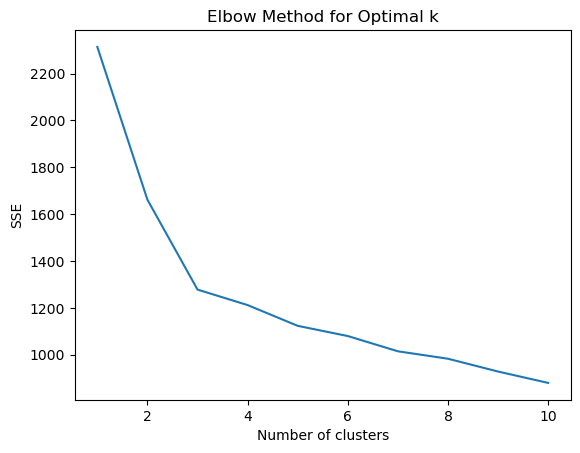

In [5]:
# Find the optimal number of clusters using the Elbow method
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(wine_data_scaled)
    sse[k] = kmeans.inertia_

# Plot the Elbow method
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.show()


# Fit K-Means with the optimal number of clusters
k_optimal = 3 # insert optimal number of clusters here
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(wine_data_scaled)

# Add cluster labels to the original dataset
wine_data["cluster_labels_kmeans"] = kmeans.labels_


# Agglomerative Clustering

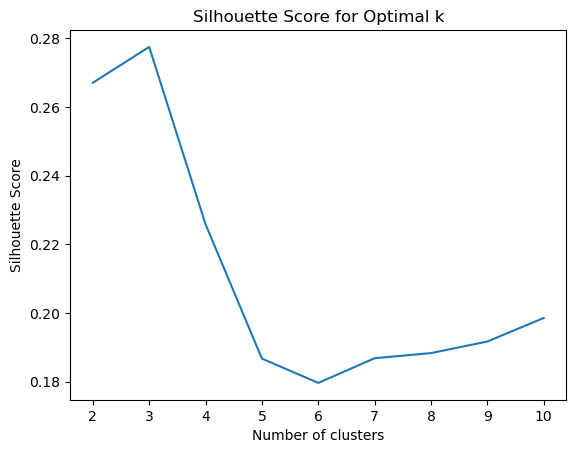

In [9]:
# Find the optimal number of clusters using the silhouette score
silhouette_scores = []
for k in range(2, 11):
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    cluster_labels = agg_clustering.fit_predict(wine_data_scaled)
    silhouette_scores.append(silhouette_score(wine_data_scaled, cluster_labels))

# Plot silhouette scores
plt.figure()
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()


# Fit Agglomerative Clustering with the optimal number of clusters
k_optimal_agg = 4  # insert optimal number of clusters here
agg_clustering = AgglomerativeClustering(n_clusters=k_optimal_agg)
agg_clustering.fit(wine_data_scaled)

# Add cluster labels to the original dataset
wine_data["cluster_labels_agg"] = agg_clustering.labels_


# PCA (Principal Component Analysis)

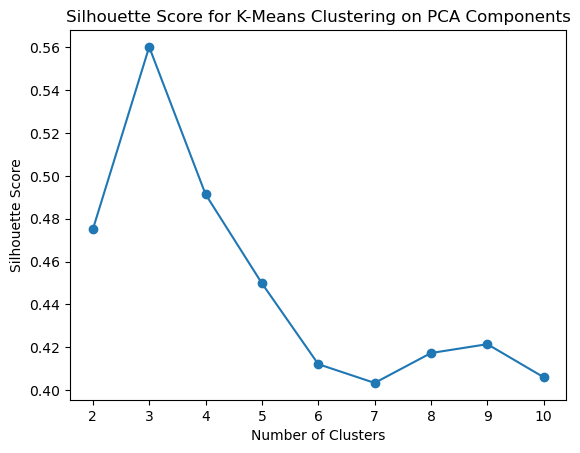

Optimal number of clusters: 3


In [11]:
# Create a range of clusters to try
cluster_range = range(2, 11)

# List to store silhouette scores for each cluster
silhouette_scores = []
pca = PCA(n_components=2)
wine_pca = pca.fit_transform(wine_data_scaled)

# Fit K-Means for each cluster and compute silhouette score
for num_clusters in cluster_range:
    kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_pca.fit(wine_pca)
    cluster_labels = kmeans_pca.labels_
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(wine_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores for different number of clusters
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means Clustering on PCA Components')
plt.show()

# Determine the optimal number of clusters based on the silhouette score
optimal_num_clusters = cluster_range[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", optimal_num_clusters)

# Fit K-Means with the optimal number of clusters
kmeans_pca_optimal = KMeans(n_clusters=optimal_num_clusters, random_state=42)
kmeans_pca_optimal.fit(wine_pca)

# Add cluster labels to the original dataset
wine_data["cluster_labels_kmeans_pca"] = kmeans_pca_optimal.labels_


# DBSCAN Clustering

In [12]:
# Determine the optimal parameters for DBSCAN
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values = [5, 10, 15, 20]

best_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(wine_data_scaled)
        if len(np.unique(cluster_labels)) > 1:  # Exclude cases with only noise
            silhouette_avg = silhouette_score(wine_data_scaled, cluster_labels)
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print("Best Silhouette Score:", best_score)
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)

# Fit DBSCAN with the optimal parameters
if best_eps is not None:  # Check if best_eps is not None before fitting DBSCAN
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan.fit(wine_data_scaled)

    # Add cluster labels to the original dataset
    wine_data["cluster_labels_dbscan"] = dbscan.labels_
else:
    print("Error: Unable to determine the best epsilon value.")

Best Silhouette Score: -1
Best eps: None
Best min_samples: None
Error: Unable to determine the best epsilon value.
